# discrate_ds3


_This notebook describes results of third run of __[Discrate](https://github.com/tsgouvea/discrate/tree/44a5b0aaa673c12397426b7949da4ddf8f641b33)__, a 2AFC task that pitches reward rate against immediacy. In each trial, rats chose freely between two choice ports with different pre- and post-choice delays. Reward probability is 0.5,_ iid _across trials. In the current version, choice is forced in half the trials, and left and right delays reverse half way through the session._

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import scipy.io as sio
import scipy as sp
import statsmodels.api as sm
from IPython.display import display, HTML

from tasks import discrate

/Users/thiago/Programs/anaconda2/envs/tasksuite/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Load single sessions (Bpod .mat files stored in same repository as this notebook) and build pandas dataframes with session summary (**dataSumm**) and single trial (**dataSing**) data:

In [2]:
path_ds3 = 'datasets/discrate_ds3/'
listSubj = next(os.walk(path_ds3))[1]
listSubj.sort()
listSess = [[]]*len(listSubj)
dataSumm = discrate.multisess()
dataSing = [[]]*len(listSubj)
indSubj = []
indDate = []

listDs = open(os.path.join('datasets','discrate_ds3.txt'),'w')

for iSubj in range(len(listSubj)) :
    subj = listSubj[iSubj]
    listSess[iSubj] = os.listdir(os.path.join(path_ds3,subj))
    listSess[iSubj].sort()
    dataSing[iSubj] = [[]]*len(listSess[iSubj])
    dates = [[]]*len(listSess[iSubj])
    for iSess in range(len(listSess[iSubj])) :
        sessName = listSess[iSubj][iSess]
        date = re.split('_',listSess[iSubj][iSess])
        dates[iSess] = date[2]
        fname = os.path.join(path_ds3,subj,sessName)
        listDs.write(fname + '\n')
        mysess = sio.loadmat(fname, squeeze_me=True)
        parsed = discrate.parser(mysess)
        parsed.parse()
        dataSumm.append(parsed)
        dataSing[iSubj][iSess] = parsed.parsedData
        indSubj.append(listSubj[iSubj])
        indDate.append(date[2])
        
listDs.close()
dataSumm.summary['subject'] = indSubj
dataSumm.summary['date'] = indDate

## Response rate depends on pre- and post-reward delays

Plot figure 1:

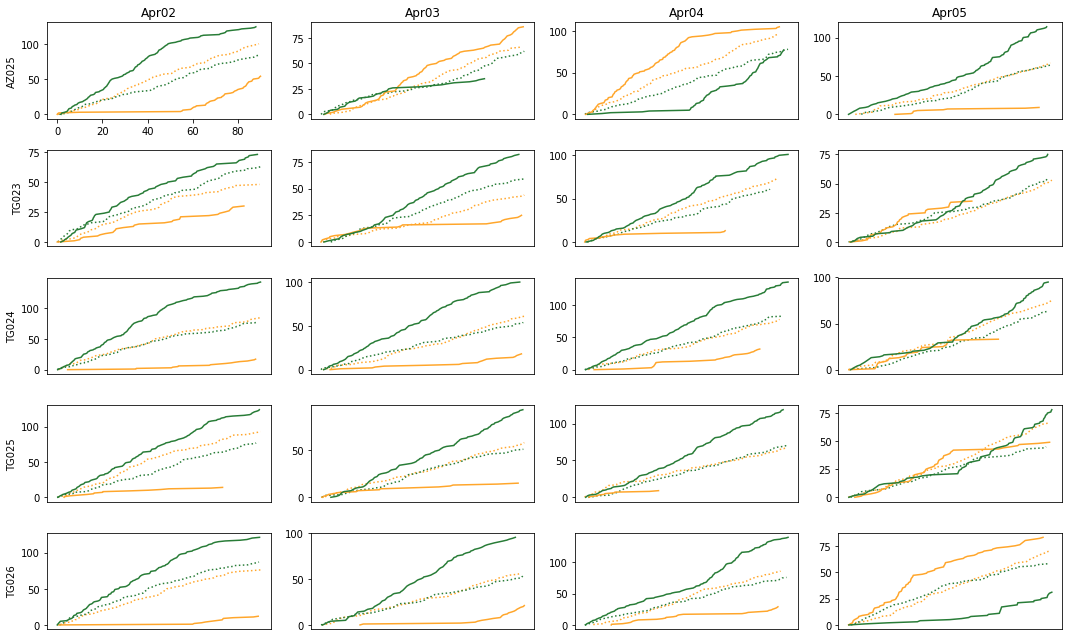

In [4]:
hf, hsps = plt.subplots(len(listSubj),len(listSess[iSubj]),figsize=(15,9))

for iSubj in range(len(listSubj)) :
    for iSess in range(len(listSess[iSubj])) :
        plt.subplot(len(listSubj),len(listSess[iSubj]),1 + (iSubj*len(listSess[iSubj])) + iSess)

        ndxChoL = dataSing[iSubj][iSess].ChoiceLeft.values
        ndxChoR = np.logical_not(ndxChoL)
        ndxForc = dataSing[iSubj][iSess].Forced.values
        
        ndx = np.logical_and(ndxChoL,ndxForc)
        plt.plot(np.asarray(dataSing[iSubj][iSess].tsState0.values[ndx]-dataSing[iSubj][iSess].tsState0.values[0])/60,np.arange(np.sum(ndx)), color='xkcd:mango', linestyle=':')
        ndx = np.logical_and(np.logical_not(ndxChoL),ndxForc)
        plt.plot(np.asarray(dataSing[iSubj][iSess].tsState0.values[ndx]-dataSing[iSubj][iSess].tsState0.values[0])/60,np.arange(np.sum(ndx)), color='xkcd:darkish green', linestyle=':')
        
        ndx = np.logical_and(ndxChoL,np.logical_not(ndxForc))
        plt.plot(np.asarray(dataSing[iSubj][iSess].tsState0.values[ndx]-dataSing[iSubj][iSess].tsState0.values[0])/60,np.arange(np.sum(ndx)), color='xkcd:mango')
        ndx = np.logical_and(np.logical_not(ndxChoL),np.logical_not(ndxForc))
        plt.plot(np.asarray(dataSing[iSubj][iSess].tsState0.values[ndx]-dataSing[iSubj][iSess].tsState0.values[0])/60,np.arange(np.sum(ndx)), color='xkcd:darkish green')
        
        if (iSess > 0 or iSubj > 0) :
            plt.xticks([])
            
        if iSess == 0 :
            plt.ylabel(listSubj[iSubj])
            
        if iSubj == 0 :
            date = re.split('_',listSess[iSubj][iSess])
            plt.title(date[2])

plt.tight_layout()

__Figure 1: Response rates__ Cumulative sum of responses at left (yellow) and right (green) choice ports as a function of time since session start. All sessions lasted 90 min. n = 5 subjects, 9 sessions each.

Display pre- and post- reward delays used in each session:

In [5]:
pivoted = pd.pivot_table(dataSumm.summary,index=['subject','date'])
display(pivoted.loc[:,pivoted.columns[::-1]])

preR  preL  posR  posL     pLeft   logOdds
subject date                                             
AZ025   Apr02   2.0   2.0   8.0   8.0  0.305556 -0.820981
        Apr03   2.0   8.0  16.0   2.0  0.707317  0.882389
        Apr04   4.0   4.0   2.0   2.0  0.576087  0.306730
        Apr05   4.0   4.0   2.0   2.0  0.080000 -2.442347
TG023   Apr02   2.0   8.0   8.0   2.0  0.295238 -0.870078
        Apr03   2.0   8.0  16.0   2.0  0.238532 -1.160744
        Apr04   4.0   4.0   2.0   2.0  0.120690 -1.985915
        Apr05   4.0   4.0   2.0   2.0  0.321429 -0.747214
TG024   Apr02   2.0   2.0   8.0   8.0  0.111801 -2.072473
        Apr03   2.0   2.0  16.0  16.0  0.158333 -1.670682
        Apr04   2.0   2.0  16.0  16.0  0.194118 -1.423473
        Apr05   4.0   4.0   2.0   2.0  0.261538 -1.037988
TG025   Apr02   2.0   8.0   8.0   2.0  0.107143 -2.120264
        Apr03   2.0   8.0  16.0   2.0  0.145455 -1.770706
        Apr04   4.0   4.0   2.0   2.0  0.076923 -2.484907
        Apr05   4.0   4.0   2.0   2.0  0.387597 -0.457425
TG026   Apr02   2.0   2.0   8.0   8.0  0.096296 -2.239072
        Apr03   2.0   2.0  16.0  16.0  0.186441 -1.473306
        Apr04   4.0   4.0   2.0   2.0  0.175439 -1.547563
        Apr05   4.0   4.0   2.0   2.0  0.724138  0.965081

**Table 1: Delays** Delays pre- and post- left and right choices, fraction of left choices, and log odds of choices

## Is choice best explained by pre-, post-, os summed-delays?

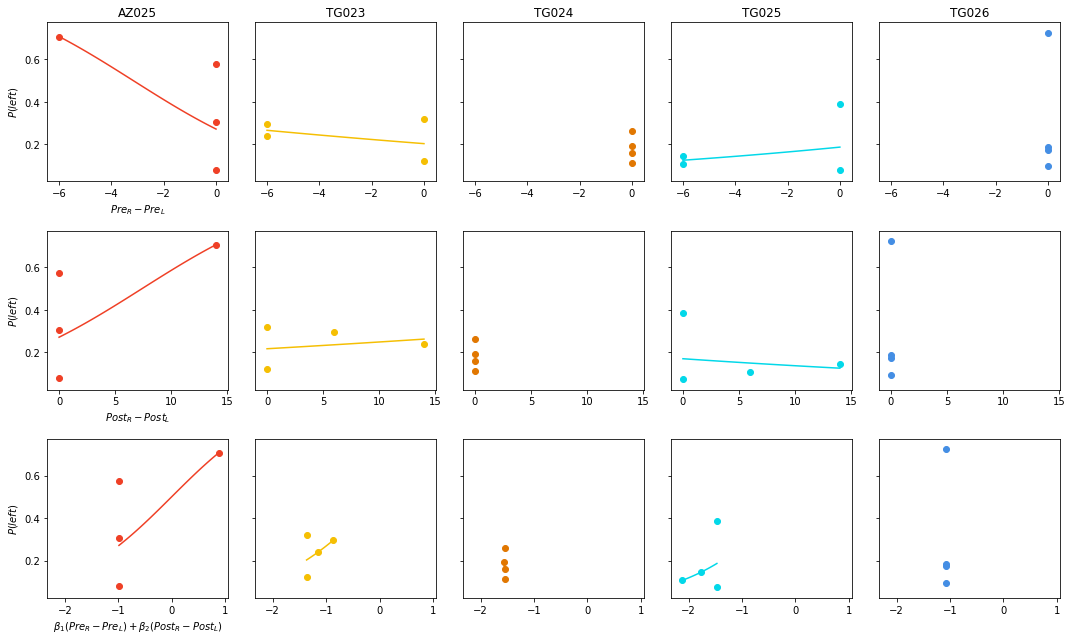

In [6]:
hf, ha = plt.subplots(3,5,sharey='all',sharex='row',figsize=(15,9))
colors = ['xkcd:tomato','xkcd:golden','xkcd:pumpkin','xkcd:aqua blue','xkcd:dark sky blue']
#mdl = [[[*len(listSubj)]*4 ]
mdl = pd.DataFrame(columns=listSubj,index=['pre','post','pre_post'])

for iSubj in range(len(listSubj)) :
    ndxSubj = dataSumm.summary.dropna(how='any').loc[:,'subject'] == listSubj[iSubj]
    
    y = dataSumm.summary.dropna(how='any').loc[ndxSubj,'pLeft']
    yLog = dataSumm.summary.dropna(how='any').loc[ndxSubj,'logOdds']
    X = dataSumm.summary.dropna(how='any')[ndxSubj]
    
    # Model 1: Pre-reward delays
    Xa = pd.Series(list(X.loc[:,'preR'] - X.loc[:,'preL']),name='preR-L',index=X.index)
    mdl.iloc[0,iSubj] = sm.OLS(yLog,sm.add_constant(Xa)).fit()

    # Model 2: Post-reward delays
    Xb = pd.Series(list(X.loc[:,'posR'] - X.loc[:,'posL']),name='posR-L',index=X.index)
    mdl.iloc[1,iSubj] = sm.OLS(yLog,sm.add_constant(Xb)).fit()

    # Model 3: Multivariate (pre- and post- independently)
    Xc = Xa.to_frame()
    Xc[Xb.name] = Xb
    mdl.iloc[2,iSubj] = sm.OLS(yLog,sm.add_constant(Xc)).fit()
    
    # PLOTTING
    ha[0][iSubj].scatter(Xa,y,color=colors[iSubj])
    xcont = np.linspace(Xa.min(),Xa.max(),50)
    ha[0][iSubj].plot(xcont,1/(1+np.exp(-mdl.iloc[0,iSubj].predict(sm.add_constant(xcont)))),color=colors[iSubj])
    ha[0][iSubj].set_title(listSubj[iSubj])
            
    ha[1][iSubj].scatter(Xb,y,color=colors[iSubj])
    xcont = np.linspace(Xb.min(),Xb.max(),50)
    ha[1][iSubj].plot(xcont,1/(1+np.exp(-mdl.iloc[1,iSubj].predict(sm.add_constant(xcont)))),color=colors[iSubj])
    
    M = mdl.iloc[2,iSubj].predict(sm.add_constant(Xc))
    ha[2][iSubj].scatter(M,y,color=colors[iSubj])
    xcont = np.linspace(M.min(),M.max(),50)
    ha[2][iSubj].plot(xcont,1/(1+np.exp(-xcont)),color=colors[iSubj])
    
    if iSubj == 0 :
        ha[0][iSubj].set_xlabel('$Pre_R - Pre_L$')
        ha[0][iSubj].set_ylabel('$P(left)$')
        ha[1][iSubj].set_xlabel('$Post_R - Post_L$')
        ha[1][iSubj].set_ylabel('$P(left)$')
        ha[2][iSubj].set_xlabel(r'$\beta_1(Pre_R - Pre_L) + \beta_2(Post_R - Post_L)$')
        ha[2][iSubj].set_ylabel('$P(left)$')

plt.tight_layout()

__Figure 2: Regresion models for P(choice)__ n = 5 subjects, 9 sessions each. Model specifications:

Model 1: $log{\frac{P_L}{(1-P_L)}} = \beta_0 + \beta_1(Pre_R - Pre_L)$

Model 2: $log{\frac{P_L}{(1-P_L)}} = \beta_0 + \beta_1(Post_R - Post_L)$

Model 3: $log{\frac{P_L}{(1-P_L)}} = \beta_0 + \beta_1(Pre_R - Pre_L) + \beta_2(Post_R - Post_L)$

Do pre- and post-reward times contribute equally to choice? Impatient subjects would weight pre-reward time more heavily, while reward rate maximazers would favor both equally.

([<matplotlib.axis.XTick at 0x1c2240be10>,
 <a list of 2 Text xticklabel objects>)

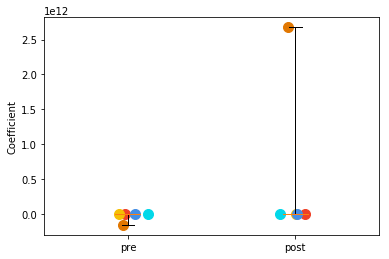

In [7]:
pre = [[]]*len(listSubj)
post = [[]]*len(listSubj)
const = [[]]*len(listSubj)

for iSubj in range(len(listSubj)) :
    const[iSubj], pre[iSubj], post[iSubj] = mdl.iloc[2,iSubj].params
    #print(listSubj[iSubj])
    #print(mdl.iloc[2,iSubj].summary())
    plt.scatter([1, 2]+np.random.randn(2)*.05, [pre[iSubj], post[iSubj] ],color=colors[iSubj],s=100)
    
plt.boxplot([pre,post],whis='range')
plt.ylabel('Coefficient')
plt.xticks([1,2],['pre','post'])

__Figure 3: Pre-reward time counts more.__ Regression coefficients for model 3 (constant not shown). Predictors have the same unit (_seconds_). Data points are single subjects, and colors are as in figure 2.